In [1]:
import swarms
import pread as pd
from numpy import linspace, logspace, pi, array, exp
import matplotlib.pyplot as plt

In [14]:
RHO=1500
M0 = 10 * 7.34767309e22; Dt = 100.; Dmax = 150000.;
M_pl = 318 * 5.972e24; a_pl = 50 * 1.496e11; R_pl = 6.9911e7
eta = 0.4; Nstr = 6.; d_pl = 10 * 3.086e16

In [41]:
t = 5e7
time = logspace(7.5, 10, 10)
waverange = logspace(-7, -3, 200)
lamb = 1.65e-6
a_plv = linspace(2 * 1.496e11, 80 * 1.496e11, 500)
type_star = "A"

In [42]:
def Finc(T_s, apl, R_s, R_pl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = (sig * T_s**4) / (pi * R_pl**2)
    return part1 * (R_s/a_pl)**2

In [43]:
def Fstar(Ls, Bnu, Ts, dpl):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = Ls * Bnu
    part2 = 4 * sig * Ts ** 4 * dpl ** 2
    return part1 / part2

In [44]:
def Fplt(B_nu_plt, R_plt, d_plt):
    return B_nu_plt * pi * R_plt ** 2 / d_plt ** 2

In [45]:
def Fscat(F_star, R_plt, g, Q, d_pl):
    return F_star * R_plt**2 * g * Q / (d_pl**2)

In [46]:
"""Access times with data.ages in years
          radii with data.radii in meters
          luminosity with data.lumin in watts
First entry is the root directory.
Second entry is the subdirectory.
Third entry is the filename.
"""
data = pd.Pread('data', 'Z002', 'pltlum_M318Z002.csv') 

In [47]:
def lum_to_temp(L, R):
    sig = 5.670367e-8 #Stefan-Boltzmann constant
    part1 = L / (4 * pi * sig * R**2)
    return (part1)**(1./4.)

In [48]:
def lum_to_temp2(R, a, T_s):
    part1 = (R / a)**0.5
    return (part1 / 2**0.5)*T_s

In [49]:
def waverange_plt():
    if type_star == "A":
        R_s = 1.7 * 6.955e08
        M_s = 2.1 * 1.989e30
        L_s = 20 * 3.828e26
    elif type_star == "G":
        R_s = 1 * 6.955e08
        M_s = 1 * 1.989e30
        L_s = 1 * 3.828e26
    elif type_star == "M":
        R_s = 0.32 * 6.955e08
        M_s = 0.21 * 1.989e30
        L_s = 0.0079 * 3.828e26

    super_fplt_list = []
    super_fscat_list = []
    super_fth_swarm_list = []
    super_fs_swarm_list = []
    for j in range(len(time)):
        fplt_list = []
        fscat_list = []
        fth_swarm_list = []
        fs_swarm_list = []
        
        s = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl, a_pl, R_pl, eta, Nstr,
                            d_pl, correction=True, alpha=1./1.2)
        s.updateSwarm(time[j])
        #T_star = s.stellarTemp()
        T_star = 8620
        B_nu = s.computeBmu(waverange, T_star)
        F_star = Fstar(L_s, B_nu, T_star, a_pl)

        for i in range(len(waverange)):
            s2 = swarms.CollSwarm(M0, Dt, Dmax, L_s, M_s, M_pl,
                                    a_pl, R_pl, eta, Nstr, d_pl,
                                    rho=RHO, fQ=5, f_vrel=4/pi,
                                    correction=True, alpha=1.2)

            s2.updateSwarm(time[j])

            # Planet Emissions
            index = data.find_time_index(time[j])
            if (index > -1):
                T_plt = lum_to_temp(data.lumin[index], data.radii[index])
                #T_plt = lum_to_temp2(R_s, a_pl, T_star)
                B_nu_plt = s2.computeBmu(waverange[i], T_plt)
                F_plt = Fstar(data.lumin[index], B_nu_plt, T_plt, d_pl)
                F_scat = Fscat(F_star[i], data.radii[index], 0.32, 0.5, d_pl)
                fplt_list.append(F_plt/1e-26)
                fscat_list.append(F_scat/1e-26)
            
            # Swarm Emissions
            F_th = s2.computeFth(array([waverange[i]]), swarm=True)
            F_s = s2.computeFs(array([waverange[i]]), 0.32, 0.08, swarm=True)

            fth_swarm_list.append(F_th[0]/1e-26)
            fs_swarm_list.append(F_s[0]/1e-26)
            
        super_fplt_list.append(fplt_list)
        super_fscat_list.append(fscat_list)
        super_fth_swarm_list.append(fth_swarm_list)
        super_fs_swarm_list.append(fs_swarm_list)
        
    contrast_rat_plt = array(fplt_list) / F_star
    return contrast_rat_plt, super_fplt_list, super_fscat_list, super_fth_swarm_list, super_fs_swarm_list

In [50]:
contrast_wave_plt, super_flux_plt, super_scat_plt, super_fth_swarm_list, super_fs_swarm_list = waverange_plt()

C:\Users\loloynage\Documents\CE-Irregular-Satellites\src\swarms.py:270: RuntimeWarning: overflow encountered in exp
  b = 1/(exp(h*(c/lamb)/(k_B*T)) - 1)


In [51]:
f_vrel = 4/pi
Qd = s.computeQd(s.Dc)
part1 = (M_s/1.989e30)**0.33 * f_vrel**0.55
part2 = (M_pl/5.972e24)**0.06 * Qd**0.15 * eta
part3 = t * (M0/5.972e24) / (RHO * (s.Dc/1000)) 

a_opt = 50 * part1 / part2 * part3**0.24 
print(a_opt)

NameError: name 's' is not defined

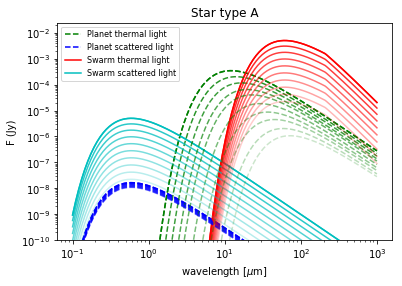

In [52]:
plt.figure(4)
a = 1.0
plt.loglog(waverange*1e6, super_flux_plt[0], 'g--', alpha=a, label="Planet thermal light")
plt.loglog(waverange*1e6, super_scat_plt[0], 'b--', alpha=a, label="Planet scattered light")
plt.loglog(waverange*1e6, super_fth_swarm_list[0], 'r', alpha=a, label="Swarm thermal light")
plt.loglog(waverange*1e6, super_fs_swarm_list[0], 'c', alpha=a, label="Swarm scattered light")
a-= 0.08
for i in range(len(super_flux_plt)):
    plt.loglog(waverange*1e6, super_flux_plt[i], 'g--', alpha=a)
    plt.loglog(waverange*1e6, super_scat_plt[i], 'b--', alpha=a)
    plt.loglog(waverange*1e6, super_fth_swarm_list[i], 'r', alpha=a)
    plt.loglog(waverange*1e6, super_fs_swarm_list[i], 'c', alpha=a)
    a-= 0.08
plt.title("Star type "+str(type_star))
plt.xlabel(r"wavelength [$\mu$m]")
plt.ylabel("F (Jy)")
plt.ylim([10e-11, 2.5e-2])
plt.legend(prop={'size': 8})
plt.show()